# Exploring Numeric Review Data

I'd like the employee review section to have a numeric summary of the source data at the top, then the subjective summary, then the links to the sources.

Design intentions:
- The numeric summary should not serve as a replacement for the sources (Glassdoor, Steam, etc)
- The user should be informed about potential sampling biases

Questions the data should answer:
- Is the company good or bad in general? Note: This will only be knowable if there are references, which there may not be
- Is the company improving or worsening?

Other considerations:
- Could I inject these summaries into the quote reducers to combat bias?

In [1]:
# Inputs:
data_folder = "../output/data"
website_folder = "../docs"

import glob

# List all JSON files in the data_folder
json_files = glob.glob(f"{data_folder}/*.json")
# print(json_files)

from unified import UnifiedResult
import json
from typing import Dict

results: Dict[str, UnifiedResult] = {}

for file_path in json_files:
    with open(file_path, 'r') as file:
        data = json.load(file)
        results[file_path] = UnifiedResult(**data)

# print(results)

In [2]:
json_files

['../output/data/Center_CenterCard.json',
 '../output/data/Nabla.json',
 '../output/data/Clarity_Pediatrics.json',
 '../output/data/Ontra.json',
 '../output/data/Taskrabbit.json',
 '../output/data/Snap_Inc_.json',
 '../output/data/Vulcan_Inc_.json',
 '../output/data/Optimize_Health.json',
 '../output/data/Akili_Interactive_EndeavorRx.json',
 '../output/data/DoubleDown_Interactive.json',
 '../output/data/2K_Games.json',
 '../output/data/ThousandEyes.json',
 '../output/data/Tavily.json',
 '../output/data/hyperparam.json',
 '../output/data/Imagine_Pediatrics.json',
 '../output/data/98point6.json',
 '../output/data/Verkada_Inc.json',
 '../output/data/Gable.json',
 '../output/data/Chewy.json',
 '../output/data/Qualtrics.json',
 '../output/data/Anduril.json',
 '../output/data/Block_Square.json',
 '../output/data/Pave_dev_Cashflow.json',
 '../output/data/Dolly.json',
 '../output/data/Yurts_ai.json',
 '../output/data/Hotel_Engine.json',
 '../output/data/Indeed.json',
 '../output/data/Hiya.json

In [49]:
example_results = [result for result in results.values() if "Singularity" in result.target.company]
example = example_results[0]


In [7]:
import numpy as np

overall_ratings = [result.glassdoor_result.raw_reviews["ratings"]["overallRating"] for result in results.values() if result.glassdoor_result]
overall_ratings

np.quantile(overall_ratings, [0.2, 0.4, 0.6, 0.8])

array([3.4, 3.6, 4. , 4.4])

In [196]:
# Note: The customer experience results don't keep all of the raw data, so we can't easily generate what we want. The Glassdoor results have it though

In [50]:
from data_sources.glassdoor import GlassdoorResult
import numpy as np
from scipy import stats

# Could be useful: raw_reviews["lastReviewDateTime"]

def summarize_sampling_local(result: GlassdoorResult, alpha=0.05) -> str:
    """Summarize the review stats compared to the overall distribution"""
    # deduplicate the reviews and warn if there are duplicates
    indexed_reviews = dict()
    for review in result.reviews:
        indexed_reviews[review.reviewId] = review
    if len(indexed_reviews) != len(result.reviews):
        print(f"Warning: {len(result.reviews) - len(indexed_reviews)} duplicate reviews found, deduplicating")
    reviews = list(indexed_reviews.values())

    sample_scores = np.array([review.ratingOverall for review in reviews])
    population_mean = result.raw_reviews["ratings"]["overallRating"]
    t_statistic, p_value = stats.ttest_1samp(sample_scores, population_mean)

    min_date = min(review.reviewDateTime for review in reviews)
    max_date = max(review.reviewDateTime for review in reviews)

    # dates as ints
    sample_dates = np.array([review.reviewDateTime.timestamp() for review in reviews])

    # spearman correlation of dates and scores
    date_score_correlation, date_score_p_value = stats.pearsonr(sample_dates, sample_scores)

    return f"""
Overall stats
Mean: {population_mean:.1f}
Count: {result.raw_reviews["ratings"]["reviewCount"]}
      
Sample stats
Mean: {sample_scores.mean():.1f}
Count: {len(sample_scores)}
Date range: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}

Sample reliability
T-statistic: {t_statistic:.3f}
P-value: {p_value:.3f}
{"Sample is significantly different" if p_value < alpha else "Sample is not significantly different"}

Date-score correlation, from the sample
Correlation: {date_score_correlation:.3f}
P-value: {date_score_p_value:.3f}
{"Correlation is significant" if date_score_p_value < alpha else "Correlation is not significant"}
"""

print(summarize_sampling_local(example.glassdoor_result))


Overall stats
Mean: 3.0
Count: 22
      
Sample stats
Mean: 3.0
Count: 22
Date range: 2021-09-25 to 2024-08-23

Sample reliability
T-statistic: 0.119
P-value: 0.906
Sample is not significantly different

Date-score correlation, from the sample
Correlation: -0.619
P-value: 0.002
Correlation is significant



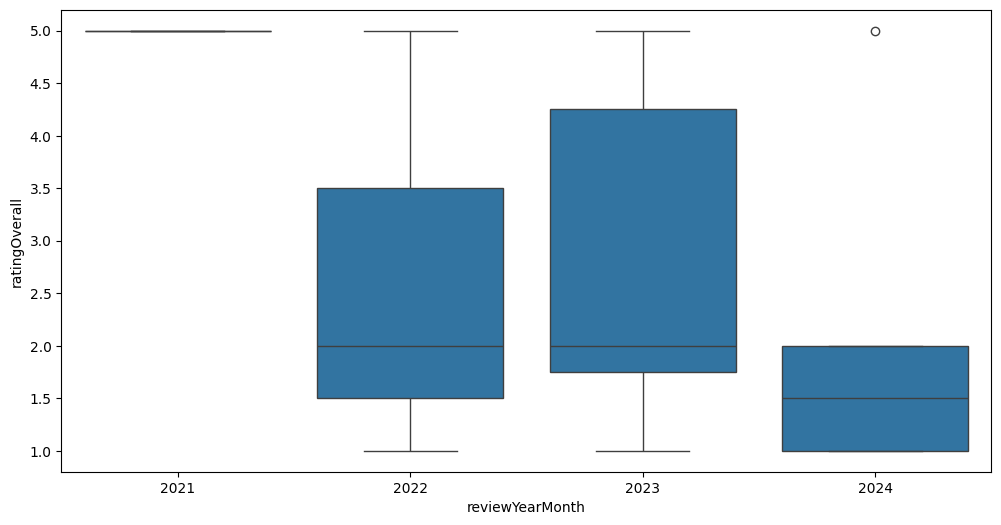

In [51]:
# graph the scores
import pandas as pd
import seaborn as sns

df = pd.DataFrame([review.model_dump() for review in example.glassdoor_result.reviews])
df["reviewYearMonth"] = df["reviewDateTime"].dt.to_period("Y")
# df

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="reviewYearMonth", y="ratingOverall")
# plt.xticks(rotation=45)
# plt.title("Overall Rating Over Time")
# plt.xlabel("Year-Month")
# plt.ylabel("Overall Rating")
plt.show()

In [ ]:
example.

In [55]:
len(example.customer_experience_result.sources.steam_reviews)

TypeError: object of type 'NoneType' has no len()

In [ ]:
google_play_df = pd.DataFrame([review.model_dump() for review in example.customer_experience_result.sources.google_play_reviews])
google_play_df["atYear"] = google_play_df["at"].dt.to_period("Y")

google_play_df

TypeError: 'NoneType' object is not iterable

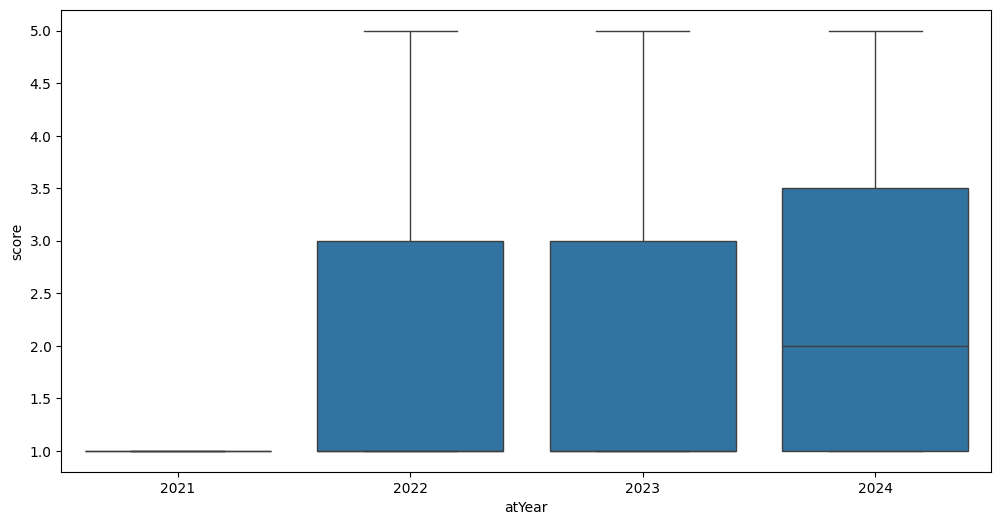

In [53]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=google_play_df.sort_values("atYear"), x="atYear", y="score")
plt.show()

In [46]:
google_play_df.corr(numeric_only=True)["score"].sort_values()

thumbsUpCount   -0.334447
score            1.000000
Name: score, dtype: float64

In [47]:
apple_df = pd.DataFrame([review.__dict__ for review in example.customer_experience_result.sources.apple_reviews])
apple_df["year"] = apple_df["date"].dt.to_period("Y")

apple_df

/tmp/ipykernel_43399/2935646195.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  apple_df["year"] = apple_df["date"].dt.to_period("Y")


,id,date,user_name,title,content,rating,app_version,year
0,12144556671,2025-01-04 09:08:55-07:00,Dhbgukfk,Good,Roos,5,2.5.0,2025
1,11812904998,2024-10-08 18:03:56-07:00,Rajean 2345,My son is more focused and loves the game,My son’s mind has gotten so much sharper and i...,5,2.5.0,2024
2,10463785646,2023-10-11 14:09:06-07:00,PlutoRobyn,Game for mind development,My son’s pediatrician recommended this game fo...,5,2.4.0,2023
3,9540410507,2023-01-23 17:01:47-07:00,fhdyx hchfdgdsjk,Endeavor RX is the best thing for me,Hi there this is Haylen I just think you are g...,5,2.1.0,2023
4,9088403390,2022-09-15 14:19:48-07:00,kjp8899,Log on doesn't work,Not sure why they ask you to create an account...,1,v1.2.1,2022
5,8984286602,2022-08-16 04:34:23-07:00,Mommy of Sad Boy,Useless,There is barely any information at all. I alr...,1,v1.2.1,2022
6,8728496943,2022-05-31 19:35:42-07:00,app is good said me,Bad Timer,Power doesn’t work it says I’ve only been goin...,1,1.1.0,2022
7,8263486537,2022-01-20 14:27:23-07:00,Hoopjrulz,Gives you zero metrics,Would be more useful to actually see trends ov...,1,1.0,2022


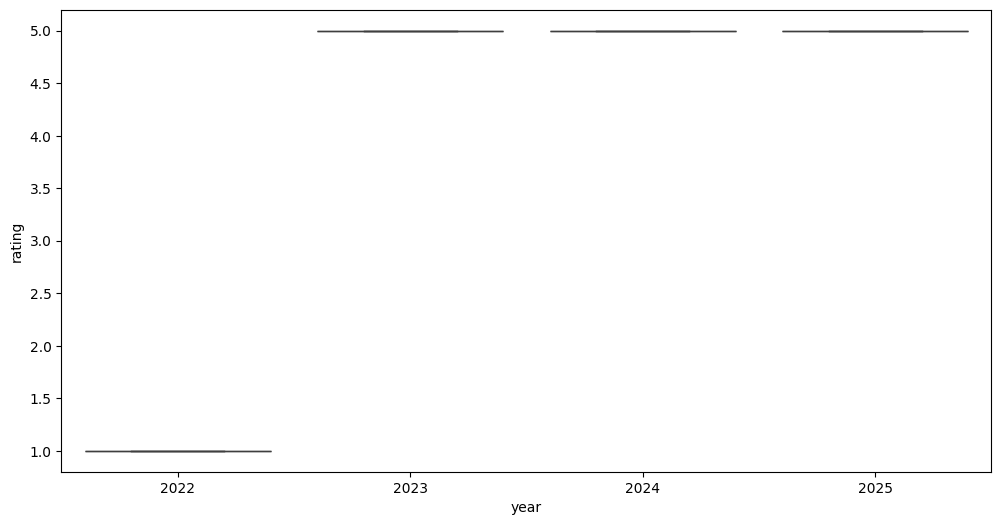

In [48]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=apple_df.sort_values("year"), x="year", y="rating")
# plt.xticks(rotation=45)
# plt.title("Overall Rating Over Time")
# plt.xlabel("Year-Month")
# plt.ylabel("Overall Rating")
plt.show()

In [198]:
example.glassdoor_result.reviews[0]

GlassdoorReview(advice='N/A', cons='- Relative to industry and experience, this role is low paid\r\n- Benefits are good but you have to pay some for health insurance which is minor but generally covered at 100% for most other tech companies\r\n- No 401k match\r\n- Team was re-structured the first week I came onboard which is typical for a start-up but somewhat difficult to navigate\r\n- Work-life-balance takes a hit: from what I can tell, most people work weekends, and late into the night because of timezone differences with various teammates being located outside the US\r\n- Concerns about the availability of promotion due to competition on the customer engineering team and new management hires\r\n- Due to being remote there are no office perks like free food, happy hour or company parties, etc', lengthOfEmployment=1, pros="- Very small, close-knit team that cares about improving constantly\r\n- CEO and CTO are very involved and know the product\r\n- A good assortment of large clients

In [199]:
import pandas as pd

def extract_ngram_weights(pipeline):
    named_weights = pd.Series(pipeline.named_steps["elasticnetcv"].coef_, index=pipeline.named_steps["tfidfvectorizer"].get_feature_names_out())

    # non-zero weights
    named_weights = named_weights[named_weights.abs() > 0]
    
    return named_weights.sort_values()

In [200]:
import pandas as pd
from sklearn.model_selection import train_test_split

# data prep
training_data = pd.DataFrame([review.__dict__ for review in example.glassdoor_result.reviews])
training_data.drop_duplicates(subset=["reviewId"], inplace=True)
training_data["jobTitle_text"] = training_data["jobTitle"].apply(lambda x: x.text if x else "Anonymous")
# training_data = training_data.dropna(subset=["jobTitle_text"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    training_data["jobTitle_text"], training_data["ratingOverall"], test_size=0.2, random_state=42
)

training_data

,advice,cons,lengthOfEmployment,pros,ratingOverall,reviewId,summary,jobTitle,reviewDateTime,employer_url_part,jobTitle_text
0,N/A,"- Relative to industry and experience, this ro...",1,"- Very small, close-knit team that cares about...",5,34547614,Great so far.,id=59727 text='Customer Engineer',2020-07-31 11:15:33.103,Sourcegraph,Customer Engineer
1,None,- None that I can think of,1,- Sourcegraph is the most transparent company ...,5,59056424,Best Company I've Worked For.,id=28424 text='Sales Development Representative',2022-02-03 11:57:50.020,Sourcegraph,Sales Development Representative
2,None,"Honestly, no meaningful cons from my POV",2,Amazing product. Amazing team. Company is very...,5,61663792,Best company I've ever worked for. Best opport...,id=32112 text='Enterprise Account Executive',2022-03-23 14:49:03.047,Sourcegraph,Enterprise Account Executive
3,None,"As with every early stage tech company, not ev...",1,- Category defining product\r\n- Top flight cu...,5,62835950,Rocketship,None,2022-04-15 11:42:33.047,Sourcegraph,Anonymous
4,"Let your teams run, let experts be experts and...",Owners/ceo/executive have a strong opinion and...,1,"Really cool people on the team, very talented ...",2,66961567,Not the best place for a marketer,id=12906 text='Marketing',2022-07-20 21:31:26.150,Sourcegraph,Marketing
5,None,terrible management with no integrity,1,the pay and the product,2,69572398,"great pay, great product, terrible management",id=15169 text='Account Executive',2022-09-28 18:36:37.463,Sourcegraph,Account Executive
6,None,There is a lack of leadership at the executive...,2,Incredible people and an opportunity to work w...,3,69898063,Great people . . . wavering leadership,None,2022-10-07 14:11:29.543,Sourcegraph,Anonymous
7,None,- No 401k matching - Too many changes in the c...,0,- People were awesome - Fully Remote,3,70160138,Good product but struggling to succeed,id=8622 text='Analyst',2022-10-14 15:27:01.003,Sourcegraph,Analyst
8,Pay closer attention to employee satisfaction ...,Managers play favorites and use intimidation t...,1,decent salary and learning opportunity on tech...,1,70194620,Filled with nepotism and collusion across depa...,id=1032570 text='Enterprise SDR',2022-10-16 11:46:26.060,Sourcegraph,Enterprise SDR
9,Be more aggressive in all aspects of product d...,Not a ton of drive to be excellent,4,"Benefits are great People are very nice, helpf...",3,70215043,Good Place to Work,id=34698 text='Individual Contributor',2022-10-17 06:28:18.770,Sourcegraph,Individual Contributor


In [203]:
# basic recipe for job title keyword correlation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline

# preprocess the Glassdoor reviews into a pandas dataframe to make this easier
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

model = make_pipeline(TfidfVectorizer(ngram_range=(1, 2), min_df=2, stop_words="english"), ElasticNetCV(l1_ratio=0.75))

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse_model = mean_squared_error(y_test, y_pred)

# Dummy regressor for baseline comparison
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(X_test)
mse_dummy = mean_squared_error(y_test, y_dummy_pred)

print(f"Dummy Regressor MSE: {mse_dummy:.3f}")
print(f"Model MSE: {mse_model:.3f}")

if mse_model >= mse_dummy:
    print("Model is not better than the dummy regressor, not refitting to all data to inspect weights")
else:
    # Refit the model on all data
    model.fit(training_data["jobTitle_text"], training_data["ratingOverall"])

    print("Feature weights")
    extract_ngram_weights(model)

Dummy Regressor MSE: 2.766
Model MSE: 3.431
Model is not better than the dummy regressor, not refitting to all data to inspect weights


In [54]:
from core import init, Seed

init()

In [61]:
import data_sources.app_stores.steam as steam

target = Seed.init("Singularity 6", "Palia", domain="singularity6.com")
url = steam.find_steam_page(target)
# url

steam_id = steam.extract_steam_id(url)

# This will be near-instant if cached! Otherwise about 5 sec
steam_reviews = steam.get_reviews(steam_id, num_reviews=5000)
steam_reviews

review_summary_stats = steam.get_review_summary_stats(steam_id)
print(review_summary_stats)

print(steam.summarize_sampling(steam_reviews, review_summary_stats))

num_reviews=1 review_score=8 review_score_desc='Very Positive' total_positive=8506 total_negative=1403 total_reviews=9909

Overall
- 85.8% positive
- Total: 9909

Sample
- 89.0% positive
- Total: 824
- Date range 2024-09-29 to 2024-10-30

Sample representativeness
- Chi-Square Statistic: 5.904
- p-value: 0.015
- The sample distribution is significantly different from the overall distribution



In [67]:
from typing import List
from collections import Counter
from datetime import datetime
import numpy as np
from scipy.stats import chi2_contingency

def summarize_sampling_local(reviews: List[steam.SteamReview], overall: steam.QuerySummary, alpha=0.05) -> str:
    sample_rating_counts = Counter(review.voted_up for review in reviews)

    # Create a contingency table
    observed = np.array([
        [sample_rating_counts[True], sample_rating_counts[False]],
        [overall.total_positive, overall.total_negative]
    ])

    # Perform the Chi-Square test
    chi2, p_value, dof, expected = chi2_contingency(observed)

    # Interpret the results
    if p_value < alpha:
        significance = "significantly different"
    else:
        significance = "not significantly different"

    min_review_date = min(review.timestamp_created for review in reviews)
    min_review_date = datetime.fromtimestamp(min_review_date)
    max_review_date = max(review.timestamp_created for review in reviews)
    max_review_date = datetime.fromtimestamp(max_review_date)

    # date correlation
    sample_dates = np.array([review.timestamp_created for review in reviews])
    date_score_correlation, date_score_p_value = stats.pearsonr(sample_dates, [review.voted_up for review in reviews])

    return f"""
Overall
- {overall.total_positive / overall.total_reviews:.1%} positive
- Total: {overall.total_reviews}

Sample
- {sample_rating_counts[True] / len(reviews):.1%} positive
- Total: {len(reviews)}
- Date range {min_review_date.strftime('%Y-%m-%d')} to {max_review_date.strftime('%Y-%m-%d')}

Sample representativeness
- Chi-Square Statistic: {chi2:.3f}
- p-value: {p_value:.3f}
- The sample distribution is {significance} from the overall distribution

Date-score correlation
- Correlation: {date_score_correlation:.3f}
- p-value: {date_score_p_value:.3f}
"""

print(summarize_sampling_local(steam_reviews, review_summary_stats))


Overall
- 85.8% positive
- Total: 9909

Sample
- 89.0% positive
- Total: 824
- Date range 2024-09-29 to 2024-10-30

Sample representativeness
- Chi-Square Statistic: 5.904
- p-value: 0.015
- The sample distribution is significantly different from the overall distribution

Date-score correlation
- Correlation: 0.036
- p-value: 0.297



In [68]:
import data_sources.app_stores.apple as apple_app_store
from core import Seed

target = Seed.init("98point6")

url = apple_app_store.find_app_store_page(target)
apple_app_store_id = apple_app_store.extract_apple_app_store_id(url)
print(apple_app_store_id)

apple_reviews = apple_app_store.scrape(apple_app_store_id)
apple_reviews

1157653928


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [69]:
import data_sources.app_stores.google_play as google_play

target = Seed.init("98point6")

url = google_play.find_google_play_page(target)
google_play_id = google_play.extract_google_play_app_id(url)
app_info = google_play.scrape_app_info(google_play_id)
google_play_reviews = google_play.scrape_reviews(google_play_id)

print(google_play.summarize_sampling(app_info, google_play_reviews))


# 98point6
On-demand, 24/7, text-based care via secure, in-app messaging.

Overall
- 3.27
- 2888 ratings
- Approximate date range Jun 26, 2017 to Jun 5, 2024

Sample
- 1.83
- 100 reviews
- Date range 2022-01-10 to 2024-10-19

Sample representativeness
- K-S Statistic: 0.386
- p-value: 0.000
- The sample distribution is significantly different from the overall distribution



In [71]:
def summarize_sampling_local(app_info: google_play.GooglePlayAppInfo, reviews: List[google_play.GooglePlayReview], alpha=0.05) -> str:
    """Summarize the review stats compared to the overall distribution"""
    sample_scores = np.array([review.score for review in reviews])
    overall_scores = google_play.histogram_to_array(app_info.histogram)

    # Perform the two-sample K-S test
    ks_statistic, p_value = stats.ks_2samp(sample_scores, overall_scores)

    # Interpret the results
    if p_value < alpha:
        significance = "significantly different"
    else:
        significance = "not significantly different"

    sample_mean = sum(review.score for review in reviews) / len(reviews)
    reviews_min_date = min(review.at for review in reviews)
    reviews_max_date = max(review.at for review in reviews)

    # date correlation
    sample_dates = np.array([review.at.timestamp() for review in reviews])
    date_score_correlation, date_score_p_value = stats.pearsonr(sample_dates, sample_scores)

    return f"""
# {app_info.title}
{app_info.summary}

Overall
- {app_info.score:.2f}
- {app_info.ratings} ratings
- Approximate date range {app_info.released} to {app_info.lastUpdatedOn}

Sample
- {sample_mean:.2f}
- {len(reviews)} reviews
- Date range {reviews_min_date.strftime('%Y-%m-%d')} to {reviews_max_date.strftime('%Y-%m-%d')}
- Date-score correlation: P={date_score_p_value:.3f}

Sample representativeness
- K-S Statistic: {ks_statistic:.3f}
- p-value: {p_value:.3f}
- The sample distribution is {significance} from the overall distribution
"""

print(summarize_sampling_local(app_info, google_play_reviews))


# 98point6
On-demand, 24/7, text-based care via secure, in-app messaging.

Overall
- 3.27
- 2888 ratings
- Approximate date range Jun 26, 2017 to Jun 5, 2024

Sample
- 1.83
- 100 reviews
- Date range 2022-01-10 to 2024-10-19
- Date-score correlation: P=0.776

Sample representativeness
- K-S Statistic: 0.386
- p-value: 0.000
- The sample distribution is significantly different from the overall distribution

